In [1]:
import codecs
import logging
from pathlib import Path

import numpy as np
#import cv2

import torch
import torch.utils.data


logger = logging.getLogger(__name__)

In [2]:
# These functions are taken from torchvision.
# https://github.com/pytorch/vision/commit/5861f14
# Credit:
# - Martin Raison (@martinraison)
# - Ricky (@rtqichen)
# - Adam Paszke (@apaszke)

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        data = np.frombuffer(data, dtype=np.uint8, offset=8)
        data = data.astype(np.int64)
        data = data.reshape(length)
        return data


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        data = np.frombuffer(data, dtype=np.uint8, offset=16)
        data = data.astype(np.float64) / 255
        data = data.reshape(length, num_rows, num_cols)
        return data

In [3]:
def download(data_dir, *urls):
    '''Downloads data at the urls into the data_dir.

    Args:
        data_dir: The directory into which the files are downloaded.
        *urls: A list of URLs to download.
    '''
    import requests
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)
    files = []

    for url in urls:
        filename = url.rpartition('/')[2]
        filename = filename.partition('#')[0]
        filename = data_dir / filename
        files.append(filename)

        resp = requests.get(url, stream=True)
        with filename.open('wb') as f:
            for chunk in resp.iter_content(None):
                f.write(chunk)

    return files


def gunzip(*filenames, unlink=False):
    '''Decompress gzipped files.

    Args:
        *filenames: List of files to decompress.
        unlink: If True, delete the original files.
    '''
    import gzip
    files = []

    for filename in filenames:
        filename = Path(filename)

        if filename.suffix == '.gz':
            dest = filename.with_suffix('')
        elif filename.suffix == '.tgz':
            dest = filename.with_suffix('.tar')
        else:
            msg = f"expected file path with extension '.gz' or '.tgz', got '{filename}'"
            raise ValueError(msg)

        files.append(dest)
        with dest.open('wb') as d:
            with gzip.open(filename, 'rb') as f:
                d.write(f.read())
        if unlink:
            filename.unlink()

    return files


def apply_transform(x, transform):
    '''Apply a transform to some input.

    The transform can be a callable or a list of transforms.
    If the transform is callable, it is applied directly to the input.
    If the transform is a list, each member is applied in order.

    Args:
        x: The input being transformed.
        transform: The transform(s) to apply.
    '''
    if transform is None:
        return x

    elif callable(transform):
        return transform(x)

    else:
        for t in transform:
            x = apply_transform(x, t)
        return x

In [4]:
class _MNISTDataset:
    def __init__(self, urls, data_dir, transform=None):
        self.urls = urls
        self.data_dir = Path(data_dir)
        self.transform = transform
        if not self.files['images'].exists(): self.download('images')
        if not self.files['labels'].exists(): self.download('labels')
        self.images = read_image_file(self.files['images'])
        self.labels = read_label_file(self.files['labels'])

    def __getitem__(self, i):
        label = self.labels[i]
        image = self.images[i]
        image = apply_transform(image, self.transform)
        return image, label

    def __len__(self):
        return len(self.images)

    def download(self, kind):
        download(self.data_dir, self.urls[kind])
        gunzip(self.gz_files[kind])

    @property
    def gz_files(self):
        return {
            kind: self.data_dir / url.rpartition('/')[2]
            for kind, url in self.urls.items()
        }

    @property
    def files(self):
        return {
            kind: gz_file.with_suffix('')
            for kind, gz_file in self.gz_files.items()
        }

In [8]:
class MNIST:
    urls = {
        'train': {
            'images': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'labels': 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        },
        'test': {
            'images': 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'labels': 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
        },
    }

    def __init__(self, data_dir='./data/mnist'):
        self.data_dir = Path(data_dir)

    def load(self, transform=None):
        train = _MNISTDataset(self.urls['train'], (self.data_dir / 'train'), transform)
        test  = _MNISTDataset(self.urls['test'],  (self.data_dir / 'test'),  transform)
        return train, test

In [9]:
class FashionMNIST:
    urls = {
        'train': {
            'images': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'labels': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        },
        'test': {
            'images': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'labels': 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        },
    }

    def __init__(self, data_dir='./data/fashion_mnist'):
        self.data_dir = Path(data_dir)

    def load(self, transform=None):
        train = _MNISTDataset(self.urls['train'], (self.data_dir / 'train'), transform)
        test  = _MNISTDataset(self.urls['test'],  (self.data_dir / 'test'),  transform)
        return train, test

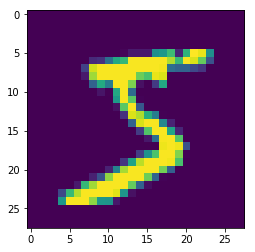

In [16]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

mnist = MNIST()
train, test = mnist.load()

dl = DataLoader(train)
xs, ys = next(iter(dl))
image, label = xs[0], ys[0]
plt.imshow(image.numpy())